In [1]:
import os
import time
import copy
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
import random
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [4]:
transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = 'data/samples/carbon/'
data = datasets.ImageFolder(os.path.join(data_dir), transform)
train_size = int(0.8 * len(data))
val_size = len(data) - train_size
data_train, data_val = torch.utils.data.random_split(data, [train_size, val_size])

batch_size = 1
trainloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=1) 
valloader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=True, num_workers=1) 
dataloaders_dict = {'train': trainloader, 'val': valloader}

In [3]:
feature_extract = True
use_pretrained = True
num_classes = 3

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
model_ft = models.squeezenet1_0(pretrained=use_pretrained)
set_parameter_requires_grad(model_ft, feature_extract)
model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
model_ft.num_classes = num_classes
input_size = 224

In [5]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history 

In [7]:
num_epochs = 15
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.6297 Acc: 0.7377
val Loss: 0.4948 Acc: 0.7853

Epoch 1/14
----------
train Loss: 0.4772 Acc: 0.8115
val Loss: 0.4654 Acc: 0.8436

Epoch 2/14
----------
train Loss: 0.4012 Acc: 0.8446
val Loss: 0.5453 Acc: 0.7699

Epoch 3/14
----------
train Loss: 0.3928 Acc: 0.8492
val Loss: 0.3840 Acc: 0.8190

Epoch 4/14
----------
train Loss: 0.3503 Acc: 0.8654
val Loss: 0.3907 Acc: 0.8344

Epoch 5/14
----------
train Loss: 0.3329 Acc: 0.8800
val Loss: 0.4412 Acc: 0.7914

Epoch 6/14
----------
train Loss: 0.3131 Acc: 0.8854
val Loss: 0.4729 Acc: 0.7975

Epoch 7/14
----------
train Loss: 0.2999 Acc: 0.8885
val Loss: 0.3264 Acc: 0.8896

Epoch 8/14
----------
train Loss: 0.3026 Acc: 0.8923
val Loss: 0.3595 Acc: 0.8681

Epoch 9/14
----------
train Loss: 0.2911 Acc: 0.8892
val Loss: 0.3469 Acc: 0.8773

Epoch 10/14
----------
train Loss: 0.2662 Acc: 0.8992
val Loss: 0.3159 Acc: 0.8834

Epoch 11/14
----------
train Loss: 0.2664 Acc: 0.8985
val Loss: 0.3641 Acc: 0.8589

Ep

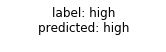

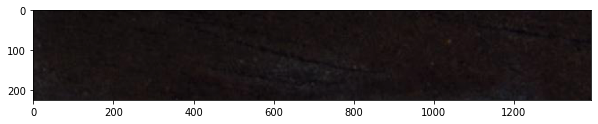

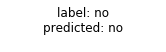

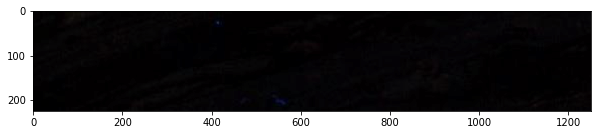

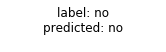

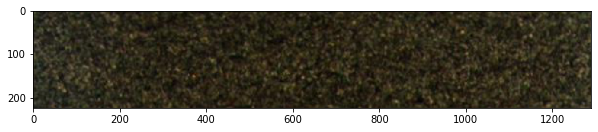

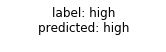

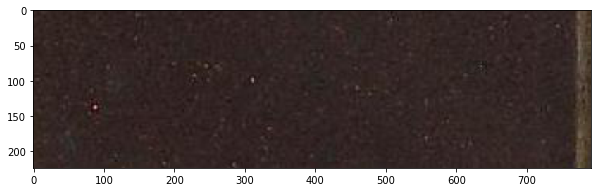

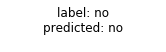

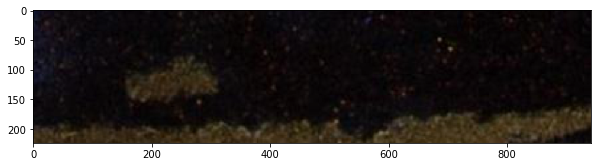

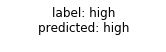

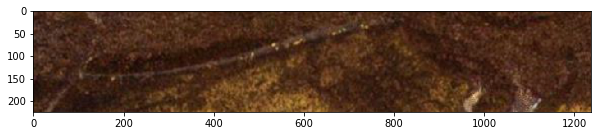

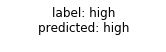

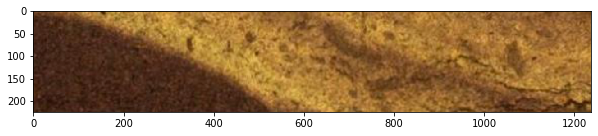

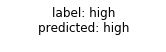

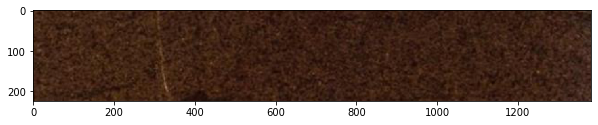

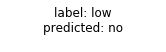

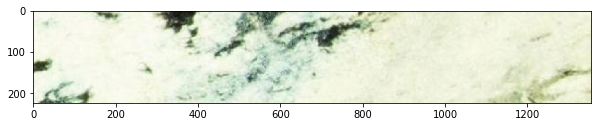

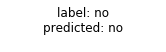

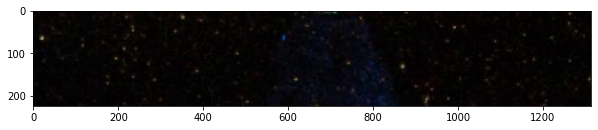

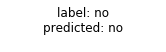

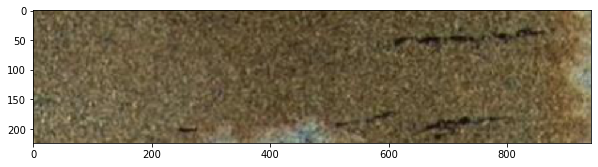

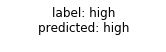

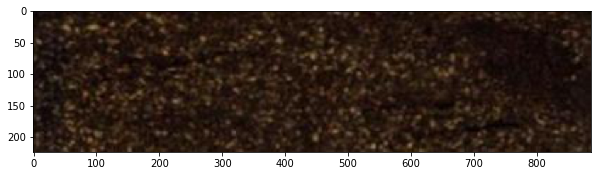

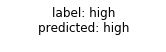

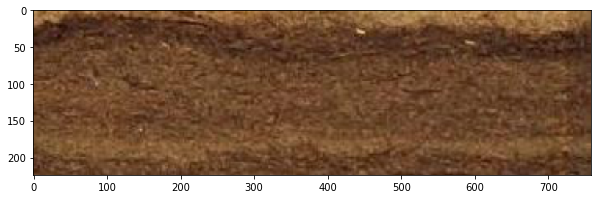

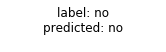

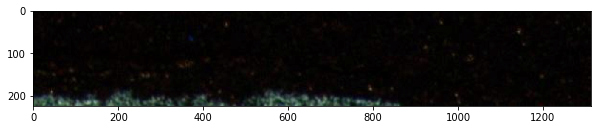

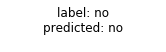

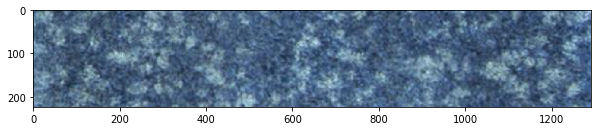

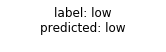

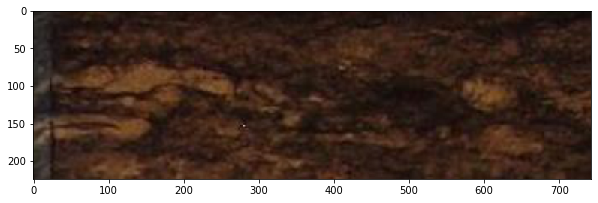

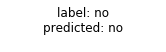

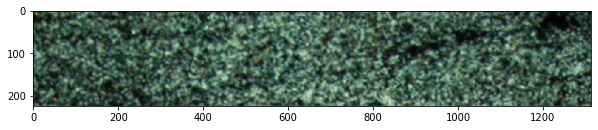

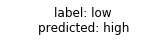

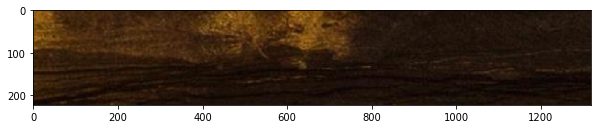

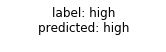

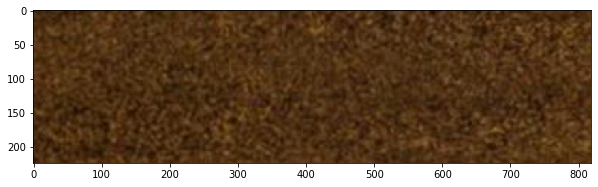

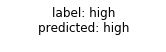

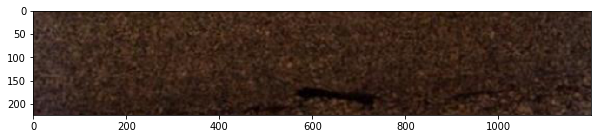

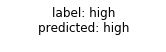

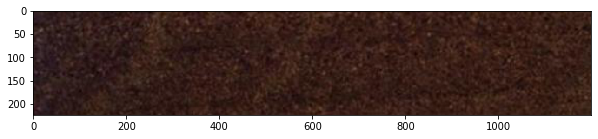

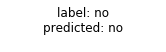

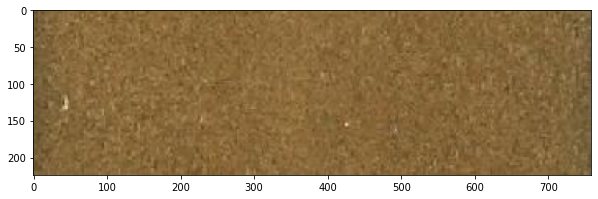

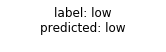

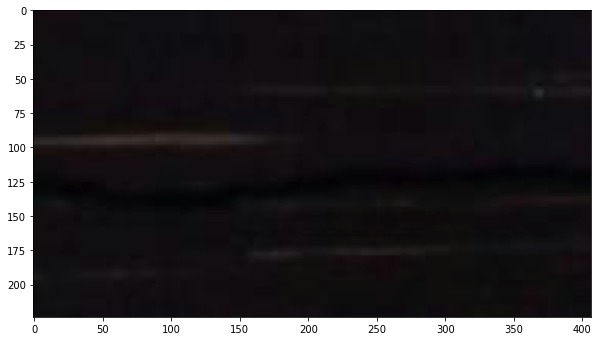

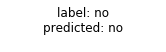

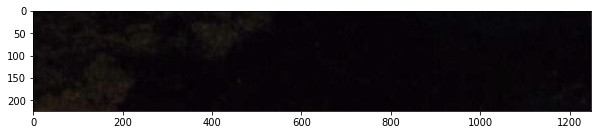

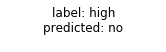

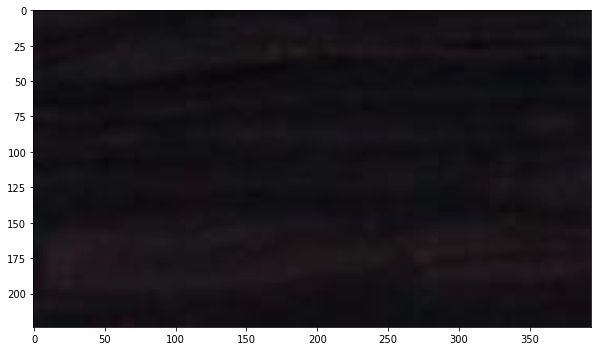

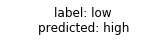

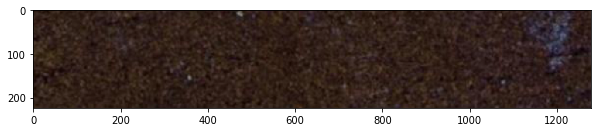

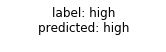

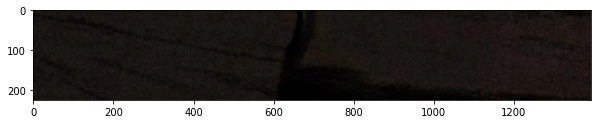

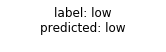

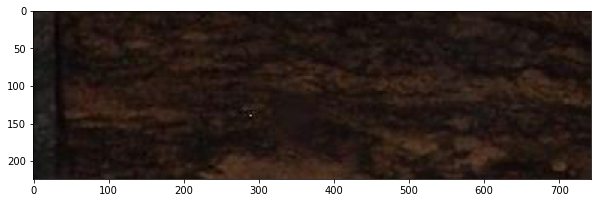

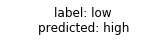

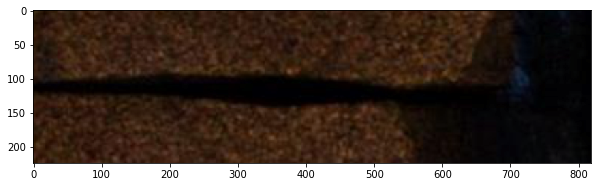

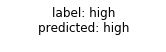

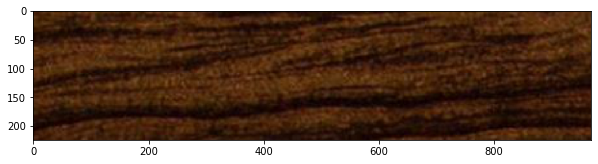

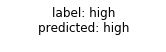

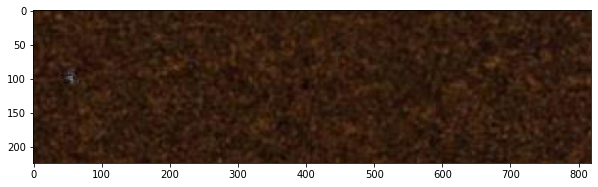

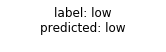

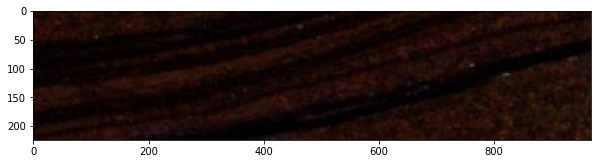

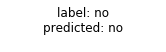

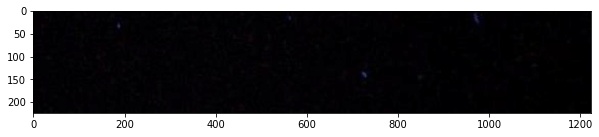

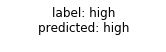

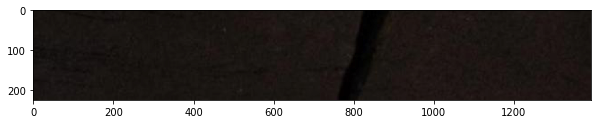

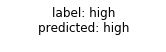

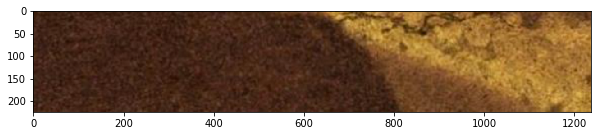

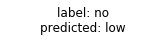

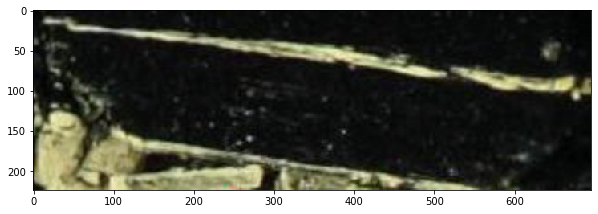

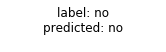

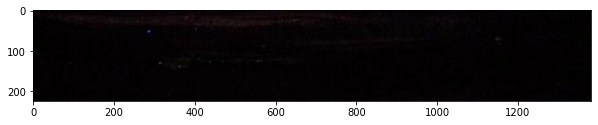

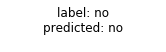

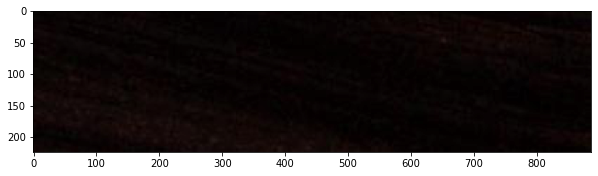

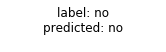

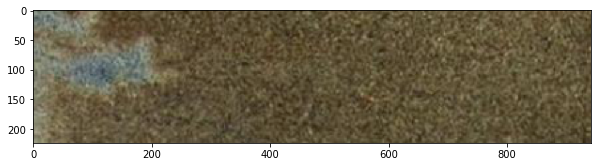

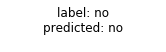

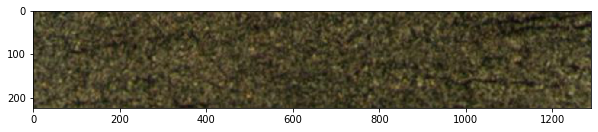

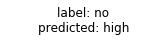

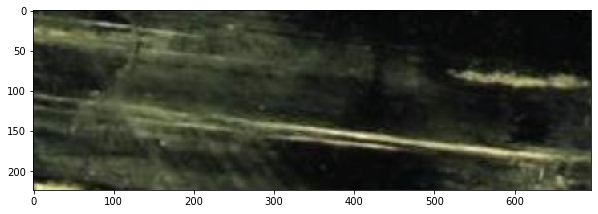

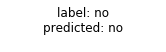

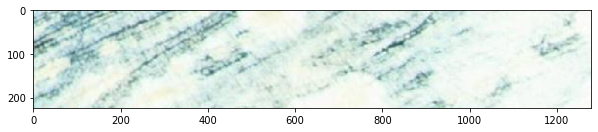

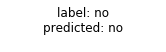

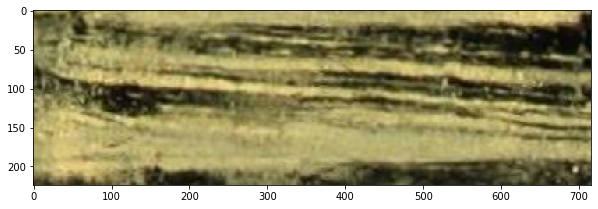

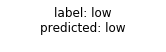

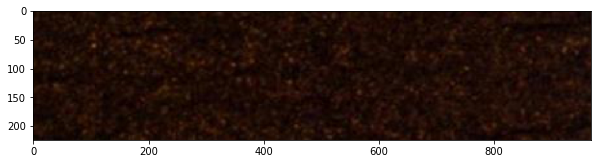

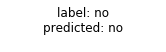

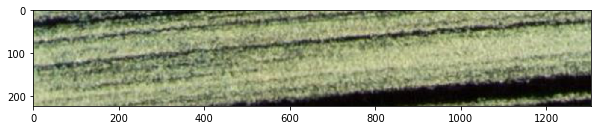

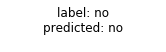

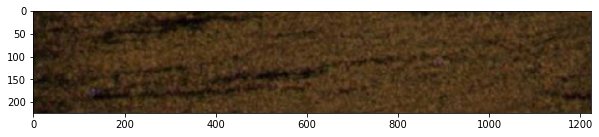

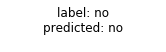

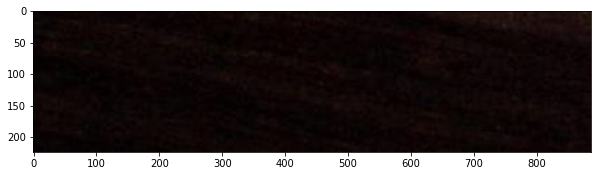

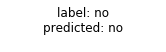

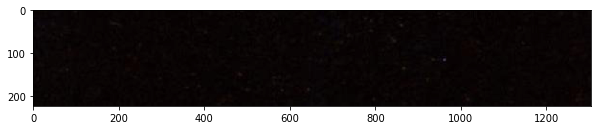

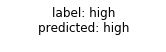

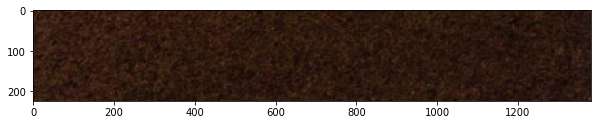

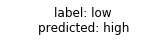

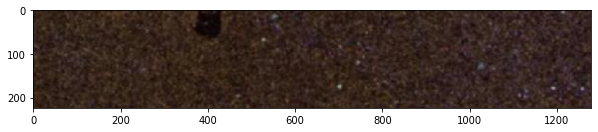

In [8]:
class_names = data.classes

def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10,40))
    plt.imshow(inp)
    plt.pause(0.001)
    
def visualize_model(model, num_images=50):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_dict['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                if labels[j].item() == 2:
                    label = 'no'
                elif labels[j].item() == 1:
                    label = 'low'
                else:
                    label = 'high'
                ax.set_title('label: '+label+'\npredicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return
        
visualize_model(model_ft)